In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.features.transforming import map_by_group
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_crosscorr_matrix,
    plot_averages_with_ci,
    plot_averages_with_ci_plt,
    plot_correlation_heatmap,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

df = df.rename({"rating": "pain_rating"})
df

trial_id,trial_number,participant_id,timestamp,temperature,pain_rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heart_rate,heart_rate_exploratory,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_r_exploratory,pupil_l_exploratory,pupil,pupil_exploratory,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,216939.4492,0.0,1.0,32.228547,32.64051,-0.411963,1342.914749,-3.709844,83.007703,83.17049,4.398393,4.389707,4.389772,4.398263,4.38977,4.398275,4.394018,4.394023,0.00001,0.00003,0.03756,0.0,0.0,0.0,243,1,0,0,1,0,0,0,0
1,1,1,217039.4492,0.000567,1.0,32.213513,32.643772,-0.430259,1311.091874,55.762577,83.811482,86.809614,4.409439,4.386315,4.389923,4.398255,4.389922,4.398247,4.394089,4.394084,0.000009,0.00003,0.039989,0.0,0.0,100.0,243,1,0,0,1,0,0,0,0
1,1,1,217139.4492,0.002514,1.0,32.253431,32.64749,-0.39406,1303.213062,-10.203914,86.547088,90.534724,4.402165,4.369497,4.389753,4.398262,4.389756,4.398263,4.394007,4.39401,0.000009,0.00003,0.04163,0.0,0.0,200.0,243,1,0,0,1,0,0,0,0
1,1,1,217239.4492,0.006091,1.0,32.318793,32.650921,-0.332128,1300.383387,4.56469,88.768386,92.99946,4.380148,4.356677,4.390118,4.398291,4.390113,4.398297,4.394205,4.394205,0.000008,0.00003,0.044792,0.0,0.0,300.0,243,1,0,0,1,0,0,0,0
1,1,1,217339.4492,0.011283,1.0,32.39749,32.654039,-0.256548,1323.898931,-2.064445,90.402729,94.161527,4.367542,4.341006,4.389776,4.398301,4.389783,4.398288,4.394039,4.394036,0.000007,0.00003,0.047939,0.0,0.0,400.0,243,1,0,0,1,0,0,0,0
1,1,1,217439.4492,0.018018,1.0,32.489363,32.656527,-0.167164,1333.865066,-6.892085,91.638658,94.314102,4.386389,4.316664,4.390356,4.398343,4.39035,4.398363,4.394349,4.394357,0.000007,0.00003,0.048997,0.0,0.0,500.0,243,1,0,0,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
480,12,42,2.8184e6,0.033976,0.0,3.033621,3.094097,-0.000643,1342.086621,-7.417371,71.357566,72.196031,3.443303,4.198385,4.173481,3.500694,4.173038,3.500694,3.837088,3.836866,0.000081,0.000767,0.008733,0.002715,0.002105,179500.0,681,6,2400,1440,0,0,0,0,0
480,12,42,2.8185e6,0.033496,0.0,3.031423,3.094058,-0.000488,1307.163293,-6.579582,71.627735,72.411536,3.456925,4.222612,4.171374,3.461206,4.172201,3.461206,3.81629,3.816704,0.000082,0.000772,0.008841,0.002749,0.002114,179600.0,681,6,2400,1440,0,0,0,0,0


In [5]:
signals = [
    "temperature",
    "pain_rating",
    "cheek_raise",
    "mouth_open",
    "upper_lip_raise",
    "nose_wrinkle",
    "brow_furrow",
]


## Averaged trials over stimulus seeds with confidence intervals

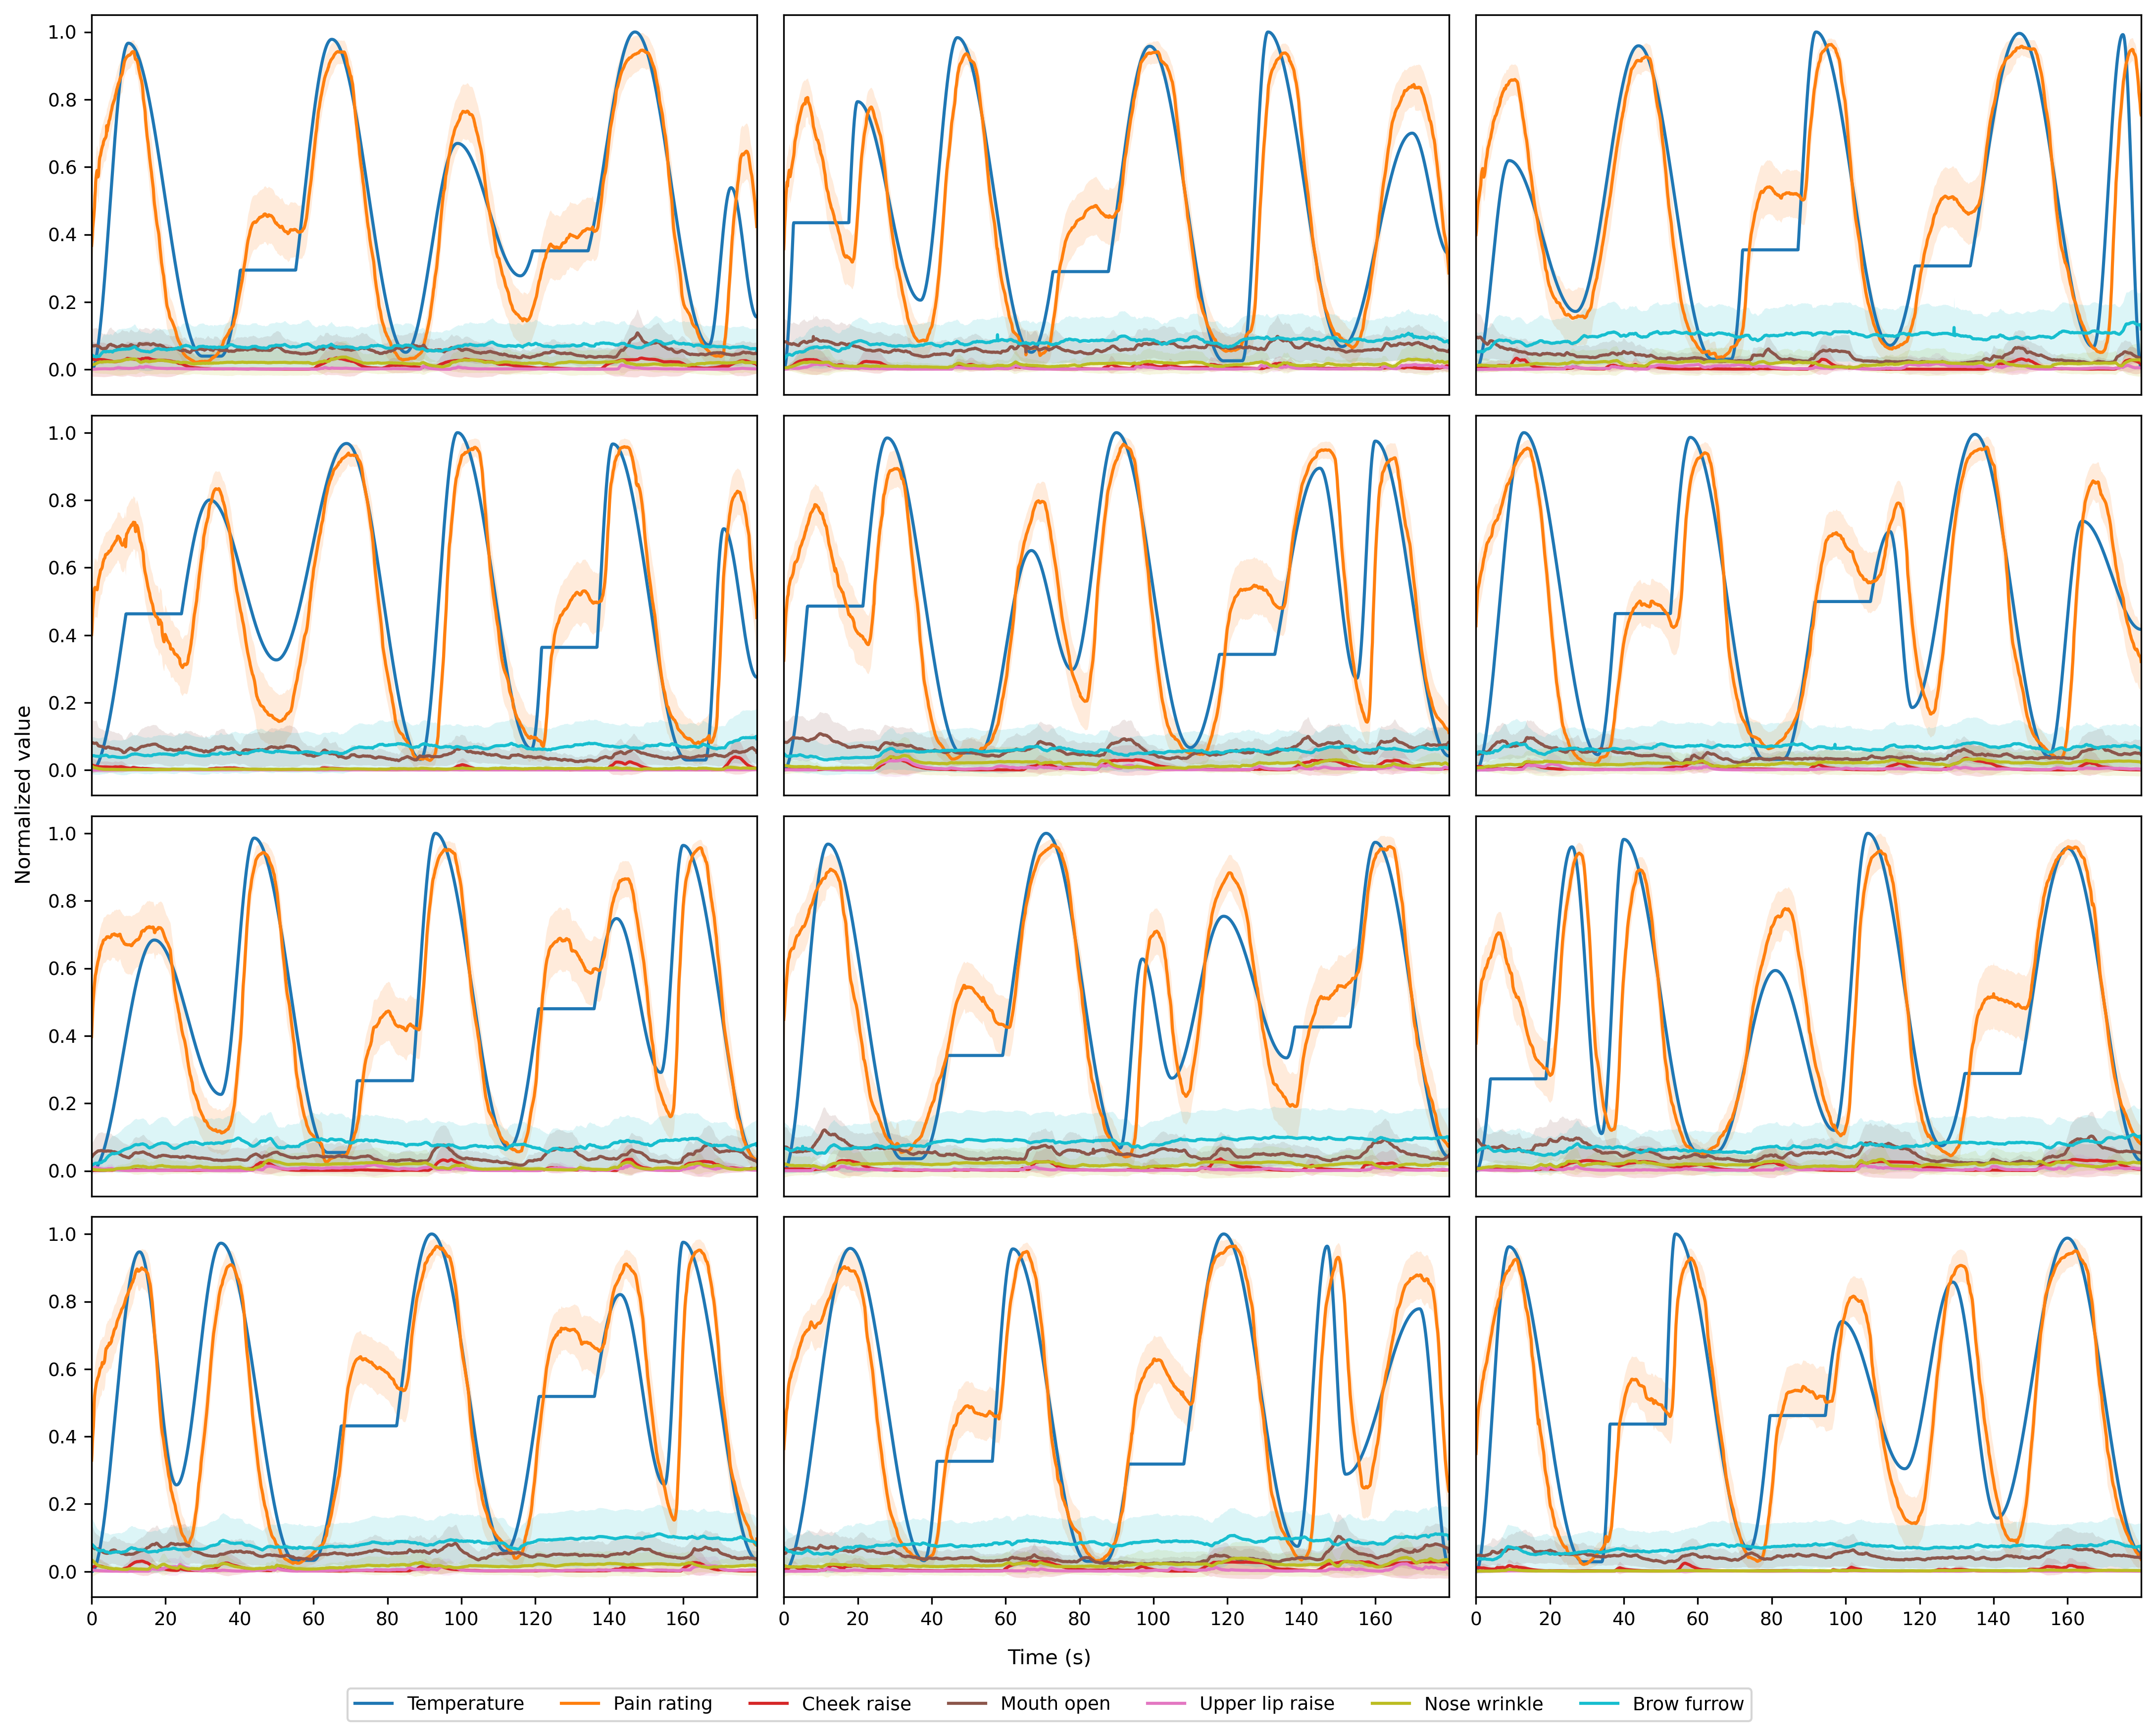

In [6]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plots = plot_averages_with_ci_plt(
    averges_with_ci,
    signals,
)

In [7]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

plots.savefig(FIGURE_DIR / "averages_over_stimulus_seeds_face.png")

In [8]:
# Remove first 20 seconds
# NOTE: important for the paper
averages = averages.filter(col("time_bin") >= 20)

In [9]:
averages

stimulus_seed,avg_temperature,avg_pain_rating,avg_cheek_raise,avg_mouth_open,avg_upper_lip_raise,avg_nose_wrinkle,avg_brow_furrow,std_temperature,std_pain_rating,std_cheek_raise,std_mouth_open,std_upper_lip_raise,std_nose_wrinkle,std_brow_furrow,sample_size,time_bin
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64
133,0.500538,0.227467,0.027172,0.063784,0.00308,0.025866,0.058926,0.000826,0.224506,0.15357,0.131294,0.01101,0.119829,0.187716,37,20.0
133,0.493263,0.215004,0.027081,0.063036,0.003047,0.025789,0.058561,0.000839,0.218409,0.153232,0.129727,0.010955,0.120048,0.187503,37,20.1
133,0.485975,0.204909,0.026941,0.061762,0.002993,0.025779,0.058235,0.000835,0.215046,0.152612,0.127054,0.010814,0.120729,0.187299,37,20.2
133,0.478646,0.196032,0.026852,0.061485,0.002938,0.025796,0.057748,0.00087,0.211645,0.152274,0.12596,0.010626,0.121343,0.186574,37,20.3
133,0.471355,0.188876,0.026717,0.061382,0.002898,0.025714,0.057762,0.000873,0.207428,0.151593,0.125702,0.010508,0.121485,0.186351,37,20.4
133,0.464048,0.1846,0.026523,0.061476,0.002851,0.025333,0.058242,0.000873,0.204376,0.150495,0.125712,0.010359,0.119671,0.186321,37,20.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
952,0.055794,0.045383,0.001338,0.041502,0.000985,0.002864,0.074018,0.000191,0.126091,0.004847,0.093918,0.003011,0.008411,0.221094,40,179.4
952,0.055265,0.042738,0.001315,0.040925,0.000968,0.002806,0.074071,0.00015,0.123876,0.004776,0.092314,0.002944,0.008124,0.22104,40,179.5


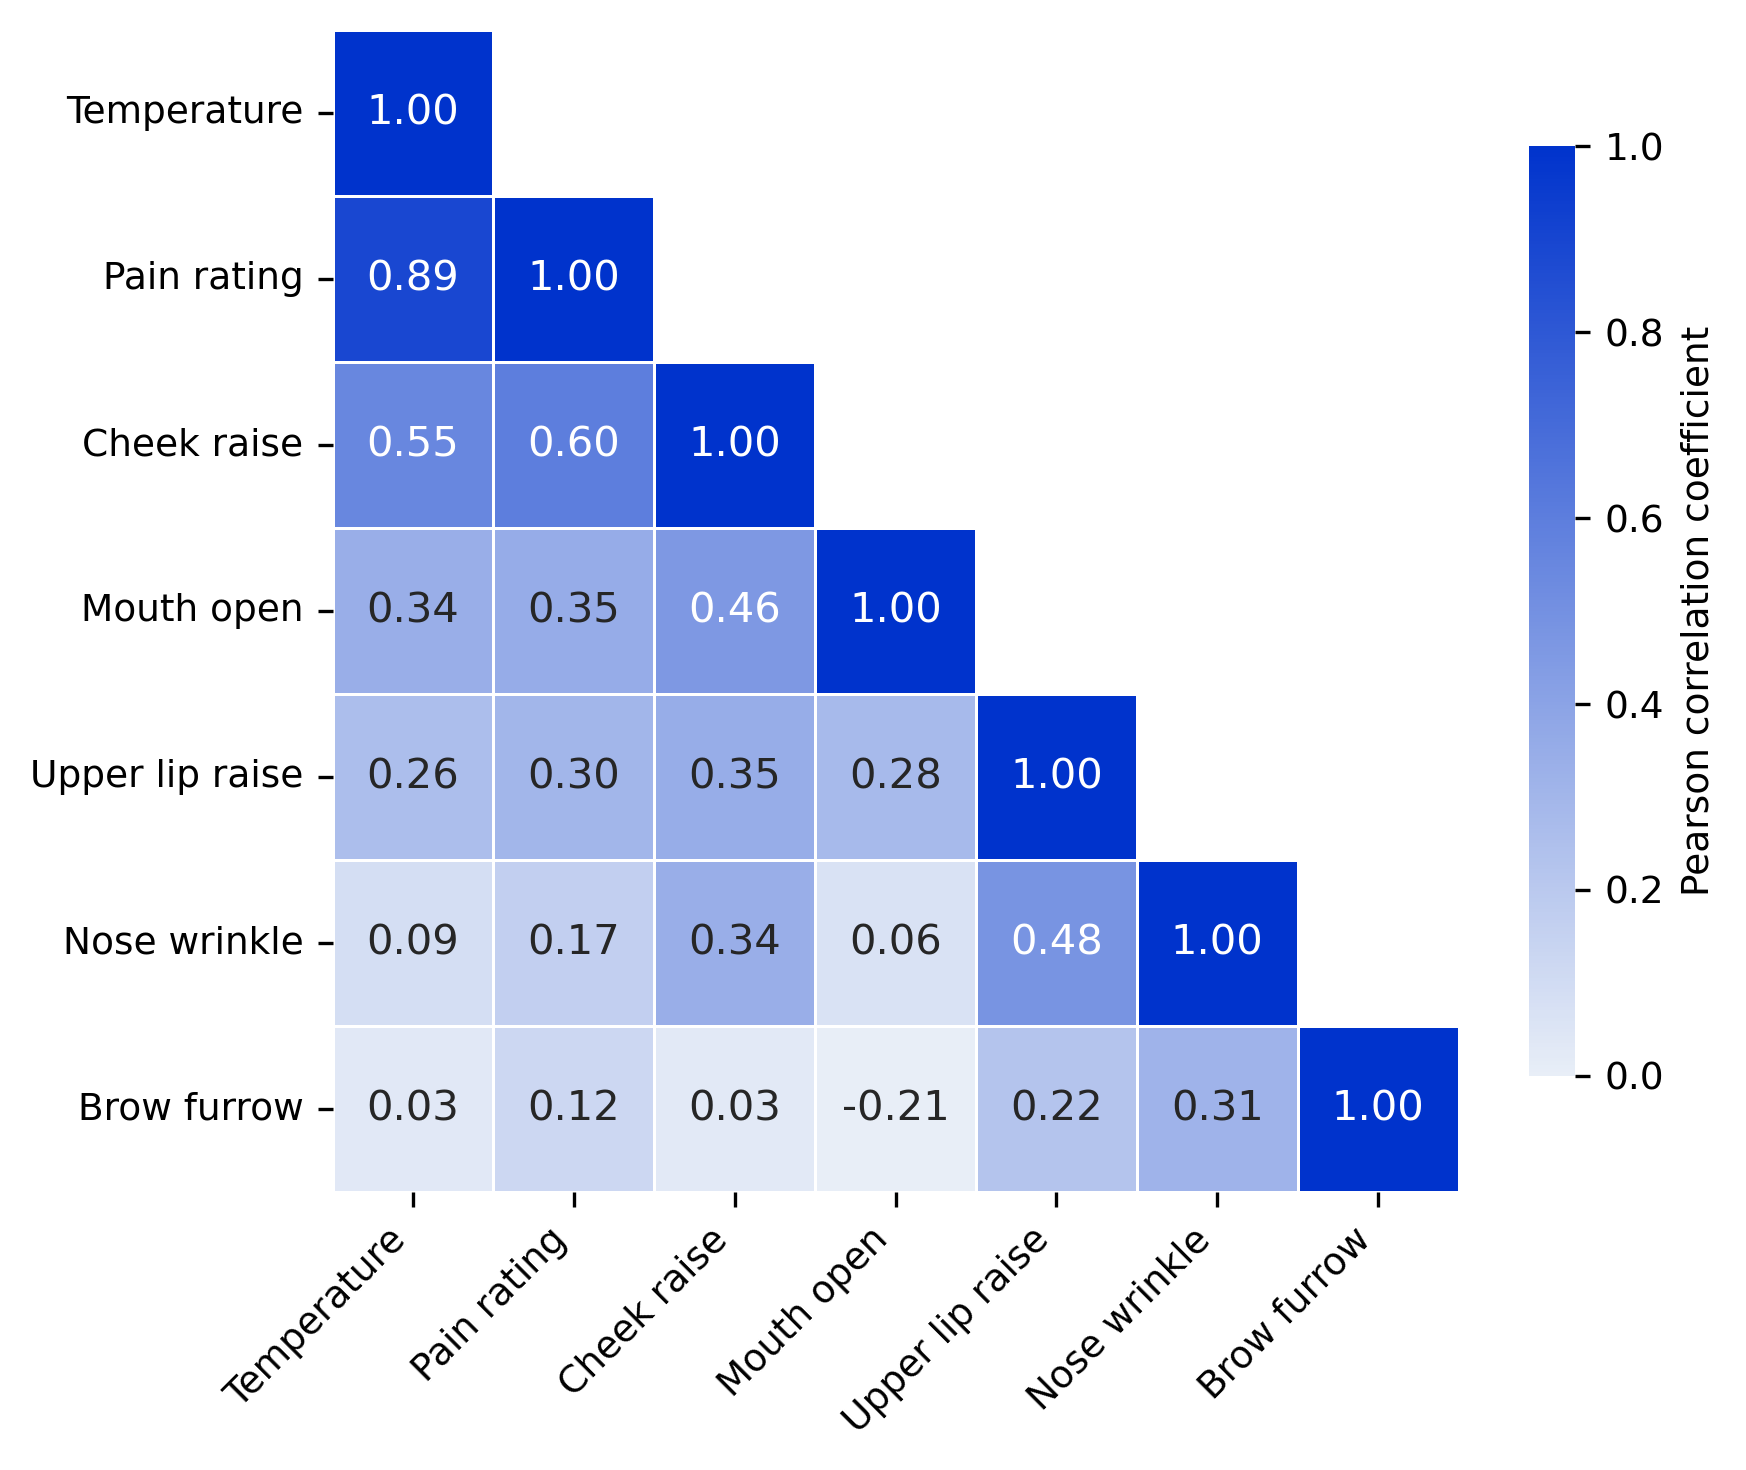

In [10]:
# without first 20 seconds
correlation_heatmap = plot_correlation_heatmap(averages, signals)

In [11]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix_face.png", dpi=300, bbox_inches="tight"
)

In [29]:
# Sample code for correlations for each stimulus seed with standard deviation
correlations = []
for group in averages.group_by("stimulus_seed"):
    corr = group[1].select(pl.corr("avg_pupil_diameter", "avg_eda_phasic")).item()
    correlations.append(corr)
correlations = np.array(correlations)
correlations.mean().round(2), correlations.std().round(2)
correlations

ColumnNotFoundError: avg_pupil_diameter

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["stimulus_seed", "avg_temperature", "avg_pain_rating", "avg_brow_furrow", ...]; PROJECT */17 COLUMNS

## Cross correlation lags of grand means

In [ ]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="temperature",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_face_results.json")
cross_corr_results

reference_signal,target_signal,mean_lag,std_lag
str,str,f64,f64
"""temperature""","""upper_lip_raise""",0.6,7.469159
"""temperature""","""nose_wrinkle""",-0.066667,3.962603
"""temperature""","""pain_rating""",-1.008333,0.335307
"""temperature""","""mouth_open""",-1.408333,1.080477
"""temperature""","""cheek_raise""",-1.941667,1.081248
"""temperature""","""brow_furrow""",-2.825,2.263892


In [15]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="pain_rating",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_face_rating_results.json")
cross_corr_results

reference_signal,target_signal,mean_lag,std_lag
str,str,f64,f64
"""pain_rating""","""nose_wrinkle""",1.683333,4.004754
"""pain_rating""","""upper_lip_raise""",1.458333,7.442049
"""pain_rating""","""temperature""",1.008333,0.335307
"""pain_rating""","""cheek_raise""",-0.516667,0.990651
"""pain_rating""","""mouth_open""",-0.55,0.600694
"""pain_rating""","""brow_furrow""",-1.875,2.343119
